<h1>0. Install and Import Dependancies</h1>

*  Install the following depenedancies to our enviroment

In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow

*  os is for formating our path names
*  cv2 is used for loading our video frames
*  numpy will be used for processing data/frames
*  matplotlib will be used for showing the image frames as we experiment
*  imagio can be used to generate a gif of the processed frames
*  gdown is a library for downloading from google drive
*  finally tensorflow for building, compiling and training our model
  *  note: using the legacy adam optimizer seems to be more stable in training

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import imageio
import gdown
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

*  the following lines limit memory growth on our GPU device
  *  note this is meant for 0-1 GPU on our machine

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
  pass

<h1>1. Build Data Loading Functions</h1>

*  use the reduced dataset from Nicholas Renotte: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
  *  full dataset for training can be found here https://spandh.dcs.shef.ac.uk//gridcorpus/
* we use gdown to download and extract the data

In [ ]:
download_url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(download_url,output,quiet=False)
gdown.extractall('data.zip')

*  define our data loading function
  *  capture frames using opencv
  *  loop through frames and convert to greyscale, crop and scale them
  *  we crop the mouth region of the videos staticaly via index slicing
  *  the original LipNet paper uses DLib to detect and extract the mouth region

In [ ]:
def load_video(path):
  capture = cv2.VideoCapture(path)
  frames = []
  for i in range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = capture.read()
    frame = tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236,80:220,:])
  capture.release()
  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames,tf.float32))
  return tf.cast((frames - mean),tf.float32)/std

*  our vocabulary is all possible characters we can generate in our sentence

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

*  create functions to convert characters to numbers and vice versa
*  the StringLookup layer will automatically make the mappings of characters to numbers for us
*  oov is the out of vocabulary token. If we encounter a character or number not in the vocabulary we just return an empty string

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    oov_token="",
    invert=True
)
print(f"Our Vocabulary is:  {char_to_num.get_vocabulary()}")
print(f"(size = {char_to_num.vocabulary_size()})")

Our Vocabulary is:  ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']
(size = 40)


*  take a path to an alignment file and return the integer tokens representing those alignments
  *  these are our labels for what is said in the video
*  ignore lines that map to "sil" as this is a special case which represents silence in the alignments

In [ ]:
def load_alignments(path):
  with open(path,'r') as f:
    lines = f.readlines()
  tokens = []
  for line in lines:
    line = line.split()
    if line[2] != 'sil':
      tokens = [*tokens, ' ', line[2]]
  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

*  load both alignments(labels) and video frames(data)
*  given a path extract the file name without the extension
  *  this code assumes a windows file path formating replace the '/' with '\\' for linux file systems
*  search our data folder for the video file path and the alignment file path that corresponds to it
*  load the two files using previously defined functions

In [ ]:
def load_data(path):
  path = bytes.decode(path.numpy())
  file_name = path.split('/')[-1].split('.')[0]
  video_path = os.path.join('data','s1',f'{file_name}.mpg')
  align_path = os.path.join('data','alignments','s1',f'{file_name}.align')
  frames = load_video(video_path)
  aligmnets = load_alignments(align_path)
  return frames, aligmnets

*  use a example path to test the data loading functions

In [ ]:
test_path = './data/s1/bbaf2n.mpg'
load_data(tf.convert_to_tensor(test_path))

*  TensorFlow Datasets require the data loading function to be wrapped in a TensorFlow py function to use it in the pipeline

In [ ]:
def mappable_load_data(path):
  res_fnc = tf.py_function(load_data, [path], (tf.float32, tf.int64))
  return res_fnc

<h1>2. Create Data Pipeline</h1>

*  create the data loading pipeline
  * we list all of the video files in our data folder
  * we then shuffle them
  * we use our mappable data loading function to grab all of the frames and alignments
  * we pad the data to ensure that each frame array is 75 frames long and each alignment is 40 characters long to ensure compatibility in the training steps
  * we also fetch 2 videos/alignments at a time
  * finally we load in the data
    *  I use the keras split_dataset function to split the data evenly in half between training and test data. This uses much more RAM(5-8GB) and thus I recommend it for systems with at least 12GB RAM
    *  Alternatively you can used the commented out take/skip method but I find this more unstable in training as well as taking significantly longer to train( aproximatly 8x slower in my experience)

In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_load_data)
data = data.padded_batch(2,padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
#train_data = data.take(450)
#test_data = data.skip(450)
train_data, test_data = tf.keras.utils.split_dataset(data, left_size=0.5)

*  visualize our frame data
  *  use imageio to create a animated gif of one of the videos and output it to the root folder of our project
  *  display a frame from frame 0-74 in our processed video useing matplotlib

In [ ]:
sample_data = data.as_numpy_iterator().next()

In [ ]:
imageio.mimsave('./lip_animation.gif',sample_data[0][0],fps=10)

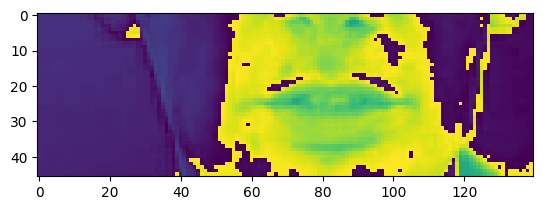

In [ ]:
frame_to_display = 15
plt.imshow(sample_data[0][0][frame_to_display])

*  display the aligment(sentence) that corresponds to the video we are visualizing

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in sample_data[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in d three soon'>

<h1>3. Design the Deep Neural Network</h1>

*  Defining the Model
  * we start with 3 sets of the following layers:
    *  3D convulotion with 3x3x3 kernals, first we use input of our 75 video frames and feed forward to our next layer. Also we use 128,256,75 kernals respectivly
    *  a ReLU activation layer
    *  a final Max Pooling layer that takes the Max values of our input in 2x2x1 squares to condense it
  *  we flatten the output of the previous step as a time series to be accepted by our LSTM layers
  *  we use LSTM(LongShortTermMemory) layers to provide the models memory (these LSTM layers will be bidrectional)
    *  note the original LipNet paper uses GRU layers instead of LSTM layers
  * we use a dropout with a 50% chance for some regularization in our model
  * finally we use a Dense softmax layer to determine which character in our vocabulary is being predicted in each step
  

In [ ]:
model = Sequential()
model.add(Conv3D(128,3,input_shape=(75,46,140,1),padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128,kernel_initializer='Orthogonal',return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128,kernel_initializer='Orthogonal',return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1,kernel_initializer='he_normal', activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

*  test our models predictions before training

In [ ]:
print('test prediction')
test_prediction = model.predict(sample_data[0])
print(tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in test_prediction[1]]))

print(f'model input shape: {model.input_shape}')
print(f'model output shape: {model.output_shape}')

<h1>4. Setup Training Options and Train</h1>

*  after 30 epochs lower the learning rate using an exponential function

In [ ]:
def scheduler(epoch,lr):
  if epoch < 30:
    return lr
  else:
    return lr *tf.math.exp(-0.1)

*  define the CTCLoss method
  *  this will lower chance of redudant predicted words
  *  this is also better performing for unaligned data if you were to take this into an app that live predicted a video feed
  *  video explaining CTC Loss: https://www.youtube.com/watch?v=GxtMbmv169o

In [ ]:
def CTCLoss(y_true,y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0],dtype="int64")
  input_len = tf.cast(tf.shape(y_pred)[1],dtype="int64")
  label_len = tf.cast(tf.shape(y_true)[1],dtype="int64")

  input_len = input_len * tf.ones(shape=(batch_len,1), dtype="int64")
  label_len = label_len * tf.ones(shape=(batch_len,1), dtype="int64")

  loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_len, label_len)
  return loss

*  use callback subclassing to show the original annotation vs the predicted anotation the model would produce at the end of each epoch

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
  def __init__(self, dataset):
    self.dataset = dataset.as_numpy_iterator()

  def on_epoch_end(self, epoch, logs=None):
    data = self.dataset.next()
    yhat = self.model.predict(data[0])
    decoded = tf.keras.backend.ctc_decode(yhat,[75,75], greedy=False)[0][0].numpy()
    for x in range(len(yhat)):
      print("Original:", tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
      print("Prediction:", tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
      print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

*  we are setting up our callbacks so that the learning rate scheduler is used our example callback is used and that at the end of each epoch we save our model weights to a checkpoint

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test_data)

*  you can toggle load_model to either load a checkpoint or train the model

In [ ]:
load_model = False
if(load_model):
  model.load_weights('./models/checkpoint')
else:
  model.fit(train_data,validation_data=test_data, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])


<h1>5. Make a Prediction</h1>

*  you can download the weights for a 100 epoch model I trained from: https://drive.google.com/u/0/uc?id=19aX5ESgsMtrOVchHb_IDK95XrqmX_-2u
*  we then can get the predictions from our test data one at a time to verify our model is working

In [ ]:
checkpoint_url = 'https://drive.google.com/u/0/uc?id=19aX5ESgsMtrOVchHb_IDK95XrqmX_-2u'
output = 'checkpoint.zip'
gdown.download(checkpoint_url, output, quiet=False)
gdown.extractall('checkpoint.zip','models')
model.load_weights('models/checkpoint')

In [ ]:
sample_data = test_data.as_numpy_iterator()

*  run this code cell each time to get a new set of two predictions from test data

In [ ]:
sample = sample_data.next()
prediction =  model.predict(sample[0])
decoded = tf.keras.backend.ctc_decode(prediction, input_length=[75,75], greedy=True)[0][0].numpy()
print('~'*30,'PREDICTIONS','~'*30)
print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded][0])
print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded][1])
print('~'*30,'REAL TEXT','~'*30)
print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]][0])
print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]][1])

1/1 [==============================] - 0s 94ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
tf.Tensor(b'bin blue by m seve soon', shape=(), dtype=string)
tf.Tensor(b'lay white by f four please', shape=(), dtype=string)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
tf.Tensor(b'bin blue by f seven soon', shape=(), dtype=string)
tf.Tensor(b'lay white by f four please', shape=(), dtype=string)


<h1>6. Test on Video</h1>

*  test specific videos by substituting in the /path/to/video and running the following code cell

In [ ]:
sample_data = load_data(tf.convert_to_tensor('/path/to/video'))
prediction = model.predict(tf.expand_dims(sample_data[0],axis=0))
decoded = tf.keras.backend.ctc_decode(prediction,input_length=[75], greedy=True)[0][0].numpy()
print('~'*30,'PREDICTIONS','~'*30)
print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded][0])
print('~'*30,'REAL TEXT','~'*30)
print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample_data[1]]][0])

1/1 [==============================] - 0s 57ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
tf.Tensor(b'bin green at n five soon', shape=(), dtype=string)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
tf.Tensor(b'bin green at n five soon', shape=(), dtype=string)
